# **PCA(Principle Component Analysis)를 이용한 Odor 분석**

---

In [9]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
%%R
package_version(R.version)

[1] ‘4.1.0’


In [11]:
%%R

.libPaths("/content/drive/MyDrive/R packages")
.libPaths()

[1] "/content/drive/MyDrive/R packages" "/usr/local/lib/R/site-library"    
[3] "/usr/lib/R/site-library"           "/usr/lib/R/library"               


## **0. Packages Installation**

In [12]:
%%R

# install.packages("corrplot")                  
# install.packages("PerformanceAnalytics")      # 상관분석 시각화
# install.packages("caret")      
# install.packages("car")            # 다중공산성   
# install.packages("ISLR")
# install.packages("pls")            # pcr 함수
# install.packages("mice")           # M.I 결측치 대체
# install.packages("stringr")
# install.packages("Metrics")        # RMSE, MAPE
# install.packages("factoextra")     # Loadings Plot
# install.packages("DAAG")           # cv.lm
# install.packages("lmtest")         # Durbin-Watson test (잔차의 독립성)

library(lmtest)
library(DAAG)
library(factoextra)
library(Metrics)
library(mice)
library(stringr)
library(pls)
library(ISLR)    
library(corrplot)
library(PerformanceAnalytics)
library(caret)
library(car)

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2

R[write to console]: Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

R[write to console]: 
Attaching package: ‘mice’


R[write to console]: The following object is masked from ‘package:stats’:

    filter


R[write to console]: The following objects are masked from ‘package:base’:

    cbind, rbind


R[write to console]: 
Attaching package: ‘pls’


R[write to console]: The following object is masked from ‘package:stats’:

    loadings


R[write to console]: corrplot 0.84 loaded

R[write to console]: 
Attaching package: ‘corrplot’


R[write to console]: The following object is masked from ‘package:pls’:

    corrplot


R[write to con

## **1. Data Preparation**

### **1) Read preprocessed data (odo)**

In [13]:
%%R

odo <- read.csv("drive/MyDrive/PLS_양돈 농가/New_data_preprocessed.csv", fileEncoding = "euc-kr")

### Scaling
odo <- as.data.frame(scale(odo, center = T, scale = T))
head(odo)

          ou        nh3         h2s       mm.1         dms         aca
1 -0.8411369 -1.0345165 -0.54687788 -0.5460465  0.01317853 -0.91595123
2 -0.8411369 -1.0228805 -0.13601504  0.1935757  7.31208325  0.69853283
3 -0.7438537 -0.9550038 -0.68258712 -0.5479616  0.84348581  0.23728812
4  0.3288898 -0.9453071 -0.05135239 -0.5479616  0.01642827 -0.07730957
5 -0.8345637 -0.9142777 -0.13103489 -0.5479616 -0.19415456 -0.23450818
6 -0.5985864 -0.9530644 -0.75504839 -0.5479616 -0.19415456 -0.33455692
         ppa         iba        bta        iva         vla         ph
1 -0.9999332 -0.96213542 -1.0319491 -0.7857508 -0.60131023 -0.5477727
2  1.7245789  1.91478326  2.0112695  1.8033594  1.40080787  0.9227162
3  0.8882999  0.96393037  1.5717432  0.9520721  0.91088996  0.0777298
4  0.4511248  0.34545646  1.1984874  0.5654885  0.15114084 -0.2257213
5  0.1819770  0.13108826  0.7403549  0.4731871  0.04651375 -0.2092467
6 -0.1333233 -0.04240923  0.7671150  0.2275147  0.01565252 -0.3165972
           pc

### **2) Data Visualizations**

#### **- 반응변수 (y)**

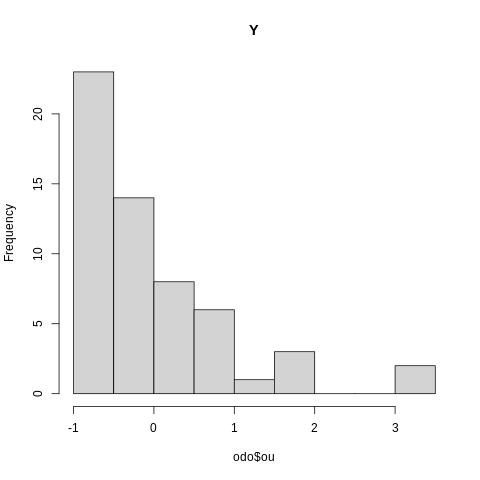

In [14]:
%%R

hist(odo$ou, main="Y")

#### **- Correlation Plot (hitmap)**

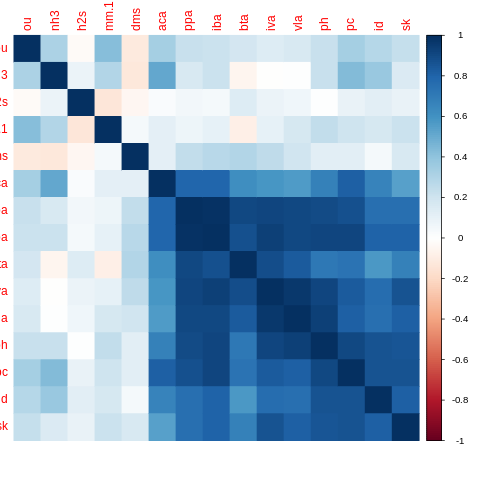

In [15]:
%%R

res <- cor(odo, method = "pearson")
corrplot::corrplot(res, method = "color", order = "original", tl.pos = "r")


#### **- Correlation Plot**

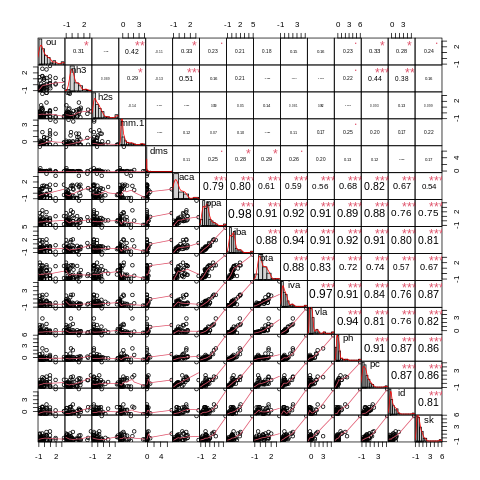

In [16]:
%%R

chart.Correlation(odo, histogram = T, pch = 5)

#### **- Correlation Values**

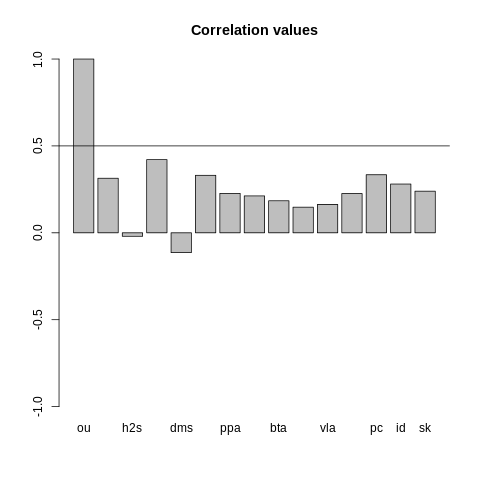

In [17]:
%%R

# 반응변수
barplot(res["ou",], ylim = c(-1,1), main = "Correlation values") ; abline(h = 0.5)

# Total
# print(res)

### **3) 다중 공선성 확인**

In [18]:
%%R

mr <- lm(ou ~ ., data = odo)

VIF <- vif(mr)
print(VIF)

       nh3        h2s       mm.1        dms        aca        ppa        iba 
  4.831220   1.270135   1.554447   1.581643  11.160878  88.300856 158.294582 
       bta        iva        vla         ph         pc         id         sk 
 24.485028 120.712215  48.704390  46.126504  33.085124   6.226120  10.656795 



 9 개 : dms aca ppa iba bta iva vla ph id

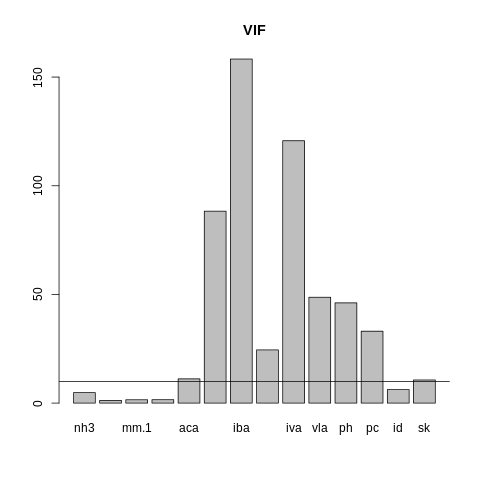

In [19]:
%%R

barplot(VIF, main = "VIF")
abline(h = 10)

cat("\n", sum(VIF > 10), "개 :", names(odo[VIF > 10]))

## **2. PCA**


### **1) PCA 분석 (odop)**

In [20]:
%%R

odop <- prcomp(odo[,2 : ncol(odo)],  center = T)

odop

Standard deviations (1, .., p=14):
 [1] 2.91008953 1.27792992 1.08250414 0.94421131 0.92287076 0.65237258
 [7] 0.42806057 0.42085711 0.31285626 0.20270043 0.15430037 0.14289306
[13] 0.10487805 0.05562329

Rotation (n x k) = (14 x 14):
            PC1           PC2          PC3         PC4         PC5          PC6
nh3  0.08452132 -0.6738054759  0.126753354  0.33407608 -0.11666367  0.122070171
h2s  0.03042357  0.0162903924  0.718411760  0.19596122  0.63258786 -0.142963761
mm.1 0.05936181 -0.3986720277 -0.550057924 -0.06651893  0.56817084 -0.413445922
dms  0.07683241  0.3281708889 -0.351897975  0.79470088  0.19062113  0.279256715
aca  0.26696198 -0.2454298016  0.086174564  0.27781917 -0.35087564 -0.317660067
ppa  0.33048731  0.0900479824  0.019817364  0.05647942 -0.13254537 -0.246992688
iba  0.33726631  0.0529772017 -0.007357794  0.07690815 -0.09880980 -0.103193390
bta  0.29197603  0.2904079561  0.096083130  0.07540909 -0.08521973 -0.369561430
iva  0.32606409  0.1919922558 -0.034918952 -0

### **2) 최적의 PCA 개수 선택 (ocomp)**

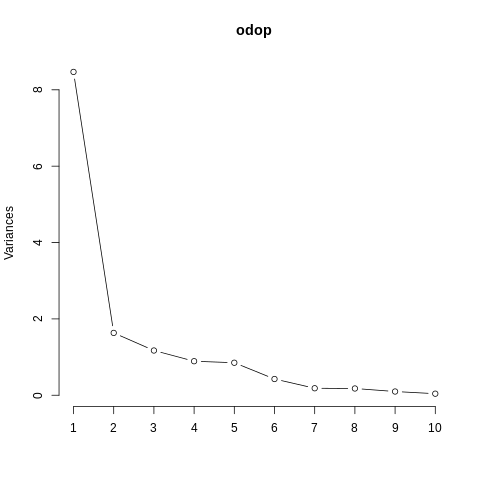

In [21]:
%%R

plot(odop, type="l")

In [22]:
%%R

### 누적 설명력이 85이 넘는 첫 PC 위치
ocomp <- which(summary(odop)$importance[3,] > 0.85)[1] 
ocomp               

PC4 
  4 


In [24]:
%%R
summary(odop)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5    PC6     PC7
Standard deviation     2.9101 1.2779 1.0825 0.94421 0.92287 0.6524 0.42806
Proportion of Variance 0.6049 0.1167 0.0837 0.06368 0.06084 0.0304 0.01309
Cumulative Proportion  0.6049 0.7216 0.8053 0.86893 0.92977 0.9602 0.97326
                           PC8     PC9    PC10   PC11    PC12    PC13    PC14
Standard deviation     0.42086 0.31286 0.20270 0.1543 0.14289 0.10488 0.05562
Proportion of Variance 0.01265 0.00699 0.00293 0.0017 0.00146 0.00079 0.00022
Cumulative Proportion  0.98591 0.99290 0.99583 0.9975 0.99899 0.99978 1.00000


### **3) New dataset**

In [25]:
%%R

pc_x <- as.matrix(odo[, 2:ncol(odo)]) %*% as.matrix(odop$rotation)
head(pc_x)

             PC1       PC2        PC3        PC4         PC5        PC6
[1,] -2.54492327 0.7492015 -0.4001538 -0.4714886 -0.09396482  0.6886541
[2,]  4.52003630 4.0027429 -2.8389760  5.1705092  1.26493438  0.9802873
[3,]  1.51454909 2.0681227 -0.5651447  0.3230466 -0.75209269 -0.8312762
[4,]  1.01827492 1.2918586  0.2936663 -0.4136312 -0.17768716  0.1399871
[5,]  0.07930694 1.2978770  0.1430277 -0.4268885 -0.29346999 -0.4176773
[6,] -0.38290024 1.3013028 -0.3067874 -0.5417673 -0.64687443 -0.3251733
             PC7         PC8          PC9         PC10         PC11        PC12
[1,]  0.19494964  0.30034531 -0.288781594  0.007219407  0.006980930 -0.15192146
[2,]  0.23984006 -0.08606826 -0.061288819  0.029479292 -0.004819967 -0.02030551
[3,] -0.25469057 -0.33447346  0.212276116 -0.249931798  0.153988392  0.02058355
[4,] -0.01392259  0.40598665  1.108669021 -0.255150129 -0.009928248 -0.10306683
[5,] -0.56960170  0.21846887  0.001135344 -0.038074612  0.003151508  0.16897843
[6,] -0.56199212

#### **- All Comp (odopa)**

In [26]:
%%R

odopa <- cbind(odo["ou"], pc_x)

head(odopa)

          ou         PC1       PC2        PC3        PC4         PC5        PC6
1 -0.8411369 -2.54492327 0.7492015 -0.4001538 -0.4714886 -0.09396482  0.6886541
2 -0.8411369  4.52003630 4.0027429 -2.8389760  5.1705092  1.26493438  0.9802873
3 -0.7438537  1.51454909 2.0681227 -0.5651447  0.3230466 -0.75209269 -0.8312762
4  0.3288898  1.01827492 1.2918586  0.2936663 -0.4136312 -0.17768716  0.1399871
5 -0.8345637  0.07930694 1.2978770  0.1430277 -0.4268885 -0.29346999 -0.4176773
6 -0.5985864 -0.38290024 1.3013028 -0.3067874 -0.5417673 -0.64687443 -0.3251733
          PC7         PC8          PC9         PC10         PC11        PC12
1  0.19494964  0.30034531 -0.288781594  0.007219407  0.006980930 -0.15192146
2  0.23984006 -0.08606826 -0.061288819  0.029479292 -0.004819967 -0.02030551
3 -0.25469057 -0.33447346  0.212276116 -0.249931798  0.153988392  0.02058355
4 -0.01392259  0.40598665  1.108669021 -0.255150129 -0.009928248 -0.10306683
5 -0.56960170  0.21846887  0.001135344 -0.038074612  0.

#### **- Best Comp (odopb)**

In [27]:
%%R

odopb <- cbind(odo["ou"], pc_x[,1:ocomp])

head(odopb)

          ou         PC1       PC2        PC3        PC4
1 -0.8411369 -2.54492327 0.7492015 -0.4001538 -0.4714886
2 -0.8411369  4.52003630 4.0027429 -2.8389760  5.1705092
3 -0.7438537  1.51454909 2.0681227 -0.5651447  0.3230466
4  0.3288898  1.01827492 1.2918586  0.2936663 -0.4136312
5 -0.8345637  0.07930694 1.2978770  0.1430277 -0.4268885
6 -0.5985864 -0.38290024 1.3013028 -0.3067874 -0.5417673


### **4) Plots**

#### **- Correlation Plot**

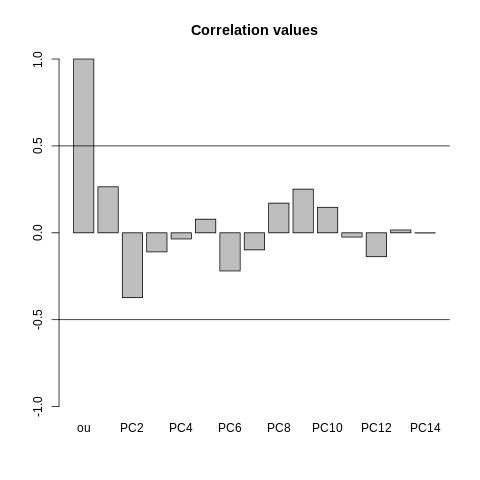

In [28]:
%%R

resp <- cor(odopa, method = "pearson")

# 반응변수
barplot(resp["ou",], ylim = c(-1, 1), main = "Correlation values") ; abline(h = c(0.5, -0.5))

# Total
# print(resp)

##### **- Correlation Plot (hitmap)**

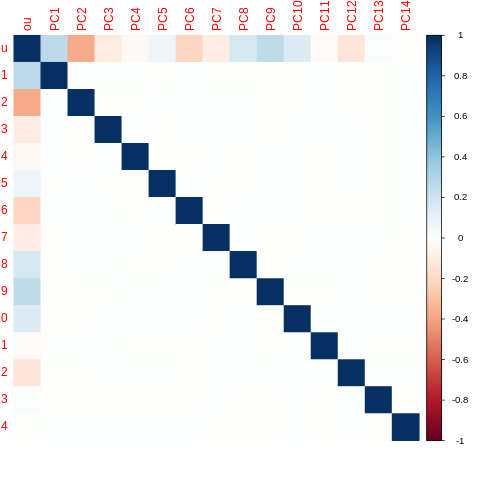

In [29]:
%%R

corrplot::corrplot(resp, method = "color", order = "original", tl.pos = "r")


##### **- Correlation Plot**

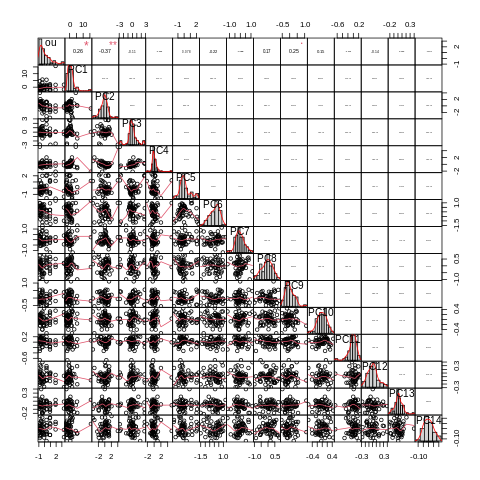

In [30]:
%%R

chart.Correlation(odopa, histogram = T, pch = 5)

#### **- Importance**

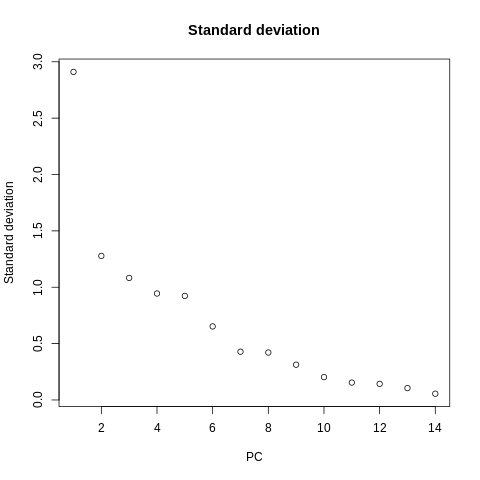

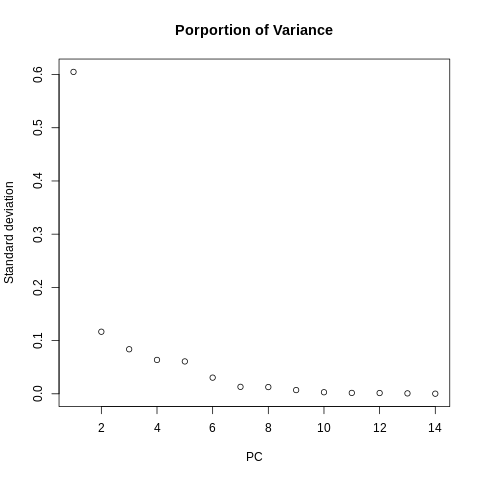

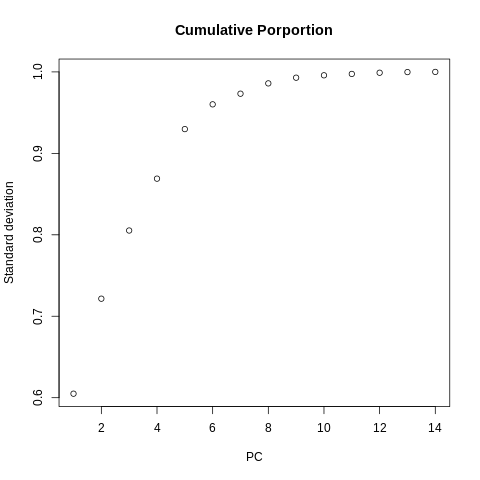

In [31]:
%%R
summary(odop)$importance
plot(summary(odop)$importance[1,], main = "Standard deviation", xlab = "PC", ylab = "Standard deviation")
plot(summary(odop)$importance[2,], main = "Porportion of Variance", xlab = "PC", ylab = "Standard deviation")
plot(summary(odop)$importance[3,], main = "Cumulative Porportion", xlab = "PC", ylab = "Standard deviation")

#### **- Loading Plot**

##### **- Variables plot**

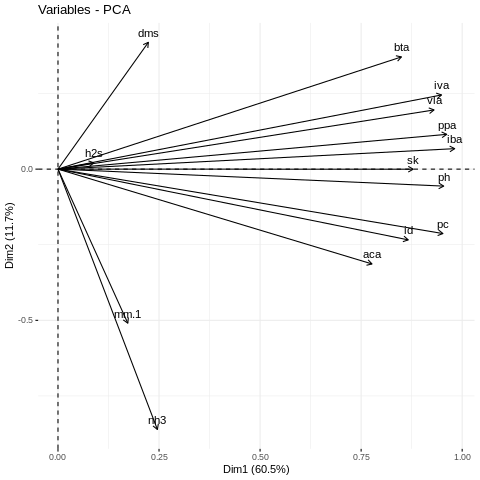

In [32]:
%%R

fviz_pca_var(odop, axes = c(1, 2))

##### **- Biplot**

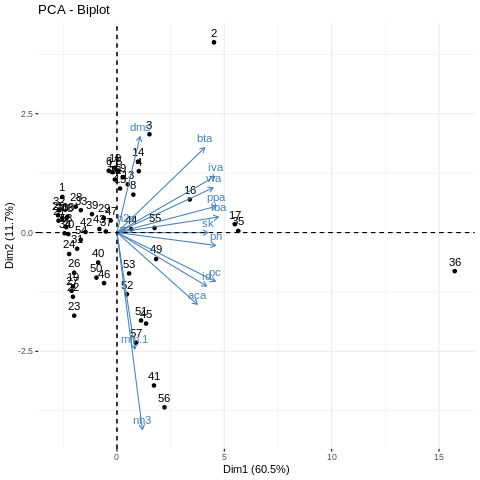

In [33]:
%%R

fviz_pca_biplot(odop, axes = c(1, 2))

## **3. PCAR**

### **1) All Components (pcaa)**

In [34]:
%%R

pcaa <- lm(ou ~ ., data = odopa)
summary(pcaa)


Call:
lm(formula = ou ~ ., data = odopa)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2567 -0.5187 -0.0950  0.3016  3.4798 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -1.461e-16  1.164e-01   0.000  1.00000   
PC1          9.099e-02  4.037e-02   2.254  0.02948 * 
PC2         -2.921e-01  9.193e-02  -3.178  0.00278 **
PC3         -1.014e-01  1.085e-01  -0.935  0.35534   
PC4         -3.748e-02  1.244e-01  -0.301  0.76472   
PC5          8.478e-02  1.273e-01   0.666  0.50903   
PC6         -3.367e-01  1.801e-01  -1.870  0.06850 . 
PC7         -2.295e-01  2.744e-01  -0.836  0.40780   
PC8          4.058e-01  2.791e-01   1.454  0.15346   
PC9          8.033e-01  3.755e-01   2.139  0.03827 * 
PC10         7.233e-01  5.795e-01   1.248  0.21891   
PC11        -1.611e-01  7.613e-01  -0.212  0.83344   
PC12        -9.622e-01  8.221e-01  -1.170  0.24843   
PC13         1.553e-01  1.120e+00   0.139  0.89041   
PC14        -2.272e-02  2.112e+00  -0.0

### **2) Best Components (pcab)**

In [35]:
%%R

pcab <- lm(ou ~ ., data = odopb)
summary(pcab)


Call:
lm(formula = ou ~ ., data = odopb)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0720 -0.5310 -0.3227  0.2289  3.4183 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -1.051e-16  1.212e-01   0.000  1.00000   
PC1          9.099e-02  4.201e-02   2.166  0.03494 * 
PC2         -2.921e-01  9.567e-02  -3.053  0.00356 **
PC3         -1.014e-01  1.129e-01  -0.898  0.37331   
PC4         -3.748e-02  1.295e-01  -0.289  0.77338   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9149 on 52 degrees of freedom
Multiple R-squared:  0.2228,	Adjusted R-squared:  0.163 
F-statistic: 3.726 on 4 and 52 DF,  p-value: 0.00969



#### **- 잔차 검정 (Best 기준)**

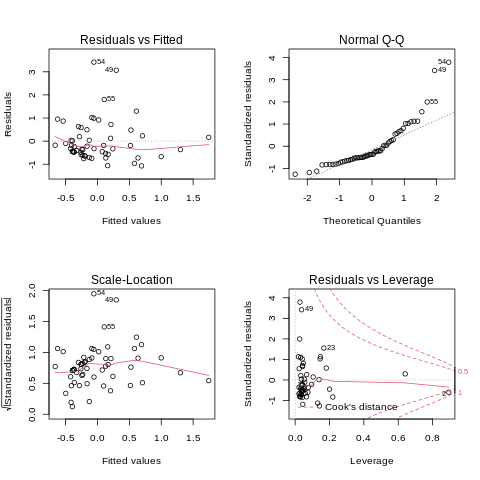

In [36]:
%%R

par(mfrow=c(2,2))
plot(pcab)
par(mfrow=c(1,1))

##### **- 잔차의 등분산성 (Breusch-Pagan test)**

- $H_0$ : 등분산성이다.  vs  $H_1$ : 등분산성이 아니다.

In [37]:
%%R

bptest(pcab)


	studentized Breusch-Pagan test

data:  pcab
BP = 0.60014, df = 4, p-value = 0.963



##### **- 잔차의 독립성 (Durbin-Watson test)**

- $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 잔차가 자기상관관계가 있다.

-  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

In [38]:
%%R

dwtest(pcab)


	Durbin-Watson test

data:  pcab
DW = 1.6911, p-value = 0.07978
alternative hypothesis: true autocorrelation is greater than 0



##### **- 잔차의 정규성 (Shapiro-test)**

- $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [39]:
%%R

pcab_res <- residuals(pcab)
shapiro.test(pcab_res)


	Shapiro-Wilk normality test

data:  pcab_res
W = 0.80931, p-value = 3.959e-07



#### **- LOOCV PCAR (Best comp 기준)**

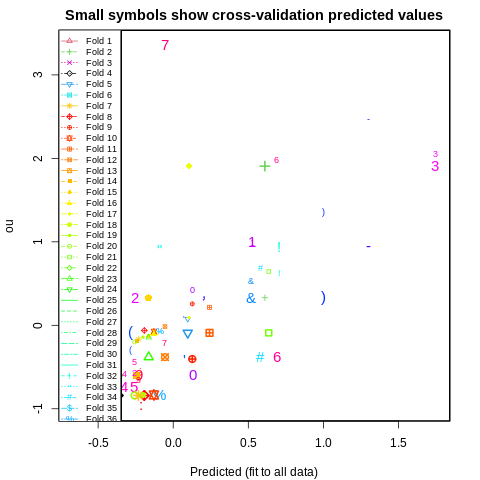

In [40]:
%%%R

cv_pcab <- cv.lm(odopb, form.lm = ou ~ ., m = nrow(odopb), printit = F)

## **4. Results (Best comp + LOO 기준)**

### **1) Validation**

In [41]:
%%R

cvlm_vp <- cv_pcab$cvpred

#### **- R-squared**

In [42]:
%%R

### R-squared
y <- odo$ou

cvlm_r2 <- cor(y, cvlm_vp)^2

cat("R2 - CV lm : ", round(cvlm_r2, 4))

R2 - CV lm :  0.0555

#### **- RMSE**

\
- $RMSE = \sqrt{{1 \over n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [43]:
%%R

cvlm_rmse <- rmse(y, cvlm_vp)

cat("RMSE - CV lm : ", round(cvlm_rmse, 4))

RMSE - CV lm :  1.0885

#### **- MAPE**

\
- Mean Absolute Precentage Error

\
- $MAPE = {100 \over n} \sum_{t=1}^n |{A_t - F_t \over A_t}|$

  - $A_t$ : True Value
  - $F_t$ : Predicted Value

In [44]:
%%R

cvlm_mape <- mape(cvlm_vp, y)

cat("MAPE - CV lm : ", round(cvlm_mape, 4))

MAPE - CV lm :  4.6201

#### **- predicted plot**

In [ ]:
%%R

plot(y, cvlm_vp,
     xlab = "True Values", ylab = "Predicted Values in Validation",
     main = "CV lm")
abline(a = 0 , b =1)

### **2) Fitted**

In [ ]:
%%R

cvlm_fp <- cv_pcab$Predicted

#### **- R-squared**

In [ ]:
%%R

### R-squared
y <- odo$ou

cvlm_fr2 <- cor(y, cvlm_fp)^2

cat("R2 - CV lm : ", round(cvlm_fr2, 4))

#### **- RMSE**

\
- $RMSE = \sqrt{{1 \over n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [ ]:
%%R

cvlm_frmse <- rmse(y, cvlm_fp)

cat("RMSE - CV lm : ", round(cvlm_frmse, 4))

#### **- MAPE**

\
- Mean Absolute Precentage Error

\
- $MAPE = {100 \over n} \sum_{t=1}^n |{A_t - F_t \over A_t}|$

  - $A_t$ : True Value
  - $F_t$ : Predicted Value

In [ ]:
%%R

cvlm_fmape <- mape(cvlm_fp, y)

cat("MAPE - CV lm : ", round(cvlm_fmape, 4))

#### **- predicted plot**

In [ ]:
%%R

plot(y, cvlm_fp,
     xlab = "True Values", ylab = "Predicted Values in Fitted",
     main = "CV lm")
abline(a = 0 , b =1)

### **3) 결과 정리**

In [ ]:
%%R

pca_valid_results <- round(c(cvlm_r2, cvlm_rmse, cvlm_mape), 3)
pca_valid_results <- t(as.data.frame(pca_valid_results))
colnames(pca_valid_results) <- c("R2", "RMSE", "MAPE")
rownames(pca_valid_results) <- c("PCA")

pca_valid_results

In [ ]:
%%R

pca_fitted_results <- round(c(cvlm_fr2, cvlm_frmse, cvlm_fmape), 3)
pca_fitted_results <- t(as.data.frame(pca_fitted_results))
colnames(pca_fitted_results) <- c("FR2", "FRMSE", "FMAPE")
rownames(pca_fitted_results) <- c("PCA")

pca_fitted_results

In [ ]:
%%R

Results <- cbind(pca_valid_results, pca_fitted_results)
# Results

write.csv(Results, file = "drive/MyDrive/PLS_양돈 농가/(Results) PCA.csv")

check_Results <- read.csv("drive/MyDrive/PLS_양돈 농가/(Results) PCA.csv", fileEncoding = "euc-kr", row.names = 1)
check_Results